In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import os
import pickle
import json
import cv2
import re

In [2]:
tf.test.is_gpu_available()

True

In [3]:
# create giant dictionary for all data
data_dir = '../mmhs150k/'
model_dir = '../fcm_replication/models/'

# load data and print sizes
tweet_dict = json.load(open(data_dir + 'MMHS150K_GT.json', 'r'))
print('Length of Tweet Dictionary:', len(tweet_dict))
print('Number of Images:', len(os.listdir(data_dir + 'img_resized')))
print('Number of Image Texts:', len(os.listdir(data_dir + 'img_txt')))

Length of Tweet Dictionary: 149823
Number of Images: 150000
Number of Image Texts: 59252


In [4]:
# method for cleaning text like in https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb
def hashtag(text):
    hashtag_body = text.group()[1:]
    if hashtag_body.isupper(): return "<hashtag> {} ".format(hashtag_body.lower())
    else: return ' '.join(["<hashtag>"] + [re.sub(r"([A-Z])",r" \1", hashtag_body, flags=re.MULTILINE | re.DOTALL)])

def allcaps(text): return text.group().lower() + ' <allcaps> '    

def clean_tweet_text(t):
    eyes = r'[8:=;]'
    nose = r"['`\-]?"
    
    t = re.sub(r'https?:\/\/\S+\b|www\.(\w+\.)+\S*', '<url>', t)
    t = re.sub(r'@\w+', '<user>', t)
    t = re.sub(r'{}{}[)dD]+|[)dD]+{}{}'.format(eyes, nose, nose, eyes), '<smile>', t)
    t = re.sub(r'{}{}p+".format(eyes, nose)', '<lolface>', t)
    t = re.sub(r'{}{}\(+|\)+{}{}'.format(eyes, nose, nose, eyes), '<sadface>', t)
    t = re.sub(r'{}{}[\/|l*]'.format(eyes, nose), '<neutralface>', t)
    t = re.sub(r'/', ' / ', t)
    t = re.sub(r'<3','<heart>', t)
    t = re.sub(r'[-+]?[.\d]*[\d]+[:,.\d]*', '<number>', t)
    t = re.sub(r'#\S+', hashtag, t)
    t = re.sub(r'([!?.]){2,}', r'\1 <repeat>', t)
    t = re.sub(r'\b(\S*?)(.)\2{2,}\b', r'\1\2 <elong>', t)
    t = re.sub(r'([A-Z]){2,}', allcaps, t)
    t = re.sub(r'{}'.format(r'[\".,-;&:]'), ' ', t)
    return t.lower()
    
print(clean_tweet_text('@SLAAATTTTT @AINTSHlTLAUGHS NIGGA...  DID YOU NOT HEAR THE CHRIS BROWN SONG?!?!?! https://t.co/1hwQMRczOw'))
print(clean_tweet_text(':) :-) 8) #HelloWorld #helloworld #Hello'))

<user> <user> nigga <allcaps>   <repeat>  did <allcaps>  you <allcaps>  not <allcaps>  hear <allcaps>  the <allcaps>  chris <allcaps>  brown <allcaps>  song <allcaps> ! <repeat> <url>
<smile> <smile> <smile> <hashtag>  hello world <hashtag> helloworld <hashtag>  hello


In [5]:
# initialize data dictionary {id: (tweet text, label)}

def get_data_list(path):
    data = []
    for id in open(data_dir + path, 'r').read().splitlines():

        # process text (tweet special tokens)
        text = tweet_dict[id]['tweet_text']
        text = clean_tweet_text(text)

        # get majority vote label
        binary_labels = [1 if n > 0 else 0 for n in tweet_dict[id]['labels']]
        label = 1 if sum(binary_labels)/len(tweet_dict[id]['labels']) > 0.5 else 0

        # save to list
        data.append((text, label))

    return data
    
train_data = get_data_list('splits/train_ids.txt')
val_data = get_data_list('splits/val_ids.txt')
test_data = get_data_list('splits/test_ids.txt')
print('Train data len:', len(train_data))
print('Val data len:', len(val_data))
print('Test data len:', len(test_data))

Train data len: 134823
Val data len: 5000
Test data len: 10000


In [6]:
# make the dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NUMBER_OF_WORDS = 20000
MAX_SEQ_LEN = 50

# training
texts, labels = zip(*train_data)
print('Longest training sequence length:', max([len(t.split()) for t in texts]))

tokenizer = pickle.load(open(model_dir + 'tokenizer.pkl', 'rb')) # use same tokenizer from LSTM
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

x_train = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)

y_train = np.asarray(labels)
print('Shape of data tensor:', x_train.shape)
print('Shape of label tensor:', y_train.shape)

# validation
val_texts, val_labels = zip(*val_data)

val_sequences = tokenizer.texts_to_sequences(val_texts) # apply train tokenizer
x_val = pad_sequences(val_sequences, maxlen=MAX_SEQ_LEN)
y_val = np.asarray(val_labels)

Longest training sequence length: 55
Found 75650 unique tokens.
Shape of data tensor: (134823, 50)
Shape of label tensor: (134823,)


In [7]:
# testing that the sequences are being build correctly
print(texts[0], sequences[0])
print(val_texts[0], val_sequences[0])
# print(tokenizer.get_config()['index_word'])

thats  what u call a redneck lol <url> [539, 36, 59, 148, 5, 77, 129, 1]
fuck my pussy chaturbate cut fingering happy tugs hot cunt tyra misoux switzerland   <url> [41, 12, 201, 19835, 529, 1009, 126, 267, 19, 13359, 1]


In [8]:
# embedding layer
from tensorflow.keras.layers import Embedding
EMBEDDING_DIM = 100

# map word to embedding
embeddings_index = {}
for line in open('../glove.twitter.27B.100d.txt'):
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')

# create embedding matrix (words without embeddings get zero embeddings)
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQ_LEN,
                            trainable=False)

In [9]:
# validation on validation set
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, GlobalMaxPooling1D, Conv1D
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(embedding_layer)

# apply word-level MLP (Dense works on last dimension)
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2)) # word level dropout

# 1D conv
model.add(Conv1D(filters=256, kernel_size=5))

# max pool and tanh
model.add(GlobalMaxPooling1D())

model.add(Dropout(0.2))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           7565100   
_________________________________________________________________
dense (Dense)                (None, 50, 256)           25856     
_________________________________________________________________
dense_1 (Dense)              (None, 50, 256)           65792     
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 256)           327936    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint(model_dir + 'best_text_cnn256.h5', 
                           save_best_only=True, 
                           monitor='val_loss', 
                           mode='min', 
                           save_weights_only=True)


history = model.fit(x_train, y_train, epochs=32, batch_size=100, 
                    validation_data=(x_val, y_val), callbacks=[mcp_save])

Train on 134823 samples, validate on 5000 samples
Epoch 1/32
134823/134823 [==============================] - 63s 467us/sample - loss: 0.4698 - accuracy: 0.7876 - val_loss: 0.7962 - val_accuracy: 0.5202
Epoch 2/32
134823/134823 [==============================] - 57s 420us/sample - loss: 0.4637 - accuracy: 0.7909 - val_loss: 0.7621 - val_accuracy: 0.5488
Epoch 3/32
134823/134823 [==============================] - 56s 419us/sample - loss: 0.4610 - accuracy: 0.7942 - val_loss: 0.7460 - val_accuracy: 0.5878
Epoch 4/32
134823/134823 [==============================] - 56s 416us/sample - loss: 0.4590 - accuracy: 0.7941 - val_loss: 0.7856 - val_accuracy: 0.5708
Epoch 5/32
134823/134823 [==============================] - 58s 427us/sample - loss: 0.4570 - accuracy: 0.7949 - val_loss: 0.7696 - val_accuracy: 0.5932
Epoch 6/32
134823/134823 [==============================] - 56s 415us/sample - loss: 0.4546 - accuracy: 0.7961 - val_loss: 0.7770 - val_accuracy: 0.5698
Epoch 7/32
134823/134823 [======

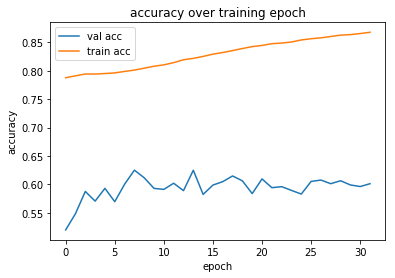

In [11]:
%matplotlib inline
plt.plot(history.history['val_accuracy'], label='val acc')
plt.plot(history.history['accuracy'], label='train acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy over training epoch')
plt.legend()
plt.show()

In [12]:
model.load_weights(model_dir + 'best_text_cnn256.h5')

In [13]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

test_texts, test_labels = zip(*test_data)

test_sequences = tokenizer.texts_to_sequences(test_texts) # apply train tokenizer
x_test = pad_sequences(test_sequences, maxlen=MAX_SEQ_LEN)
y_test = np.asarray(test_labels)

# get AUROC
preds = model.predict(x_test)
print('Test AUROC:', roc_auc_score(y_test, preds))

# get loss and acc
preds_bin = np.array(preds)
preds_bin[preds >= 0.5] = 1
preds_bin[preds < 0.5] = 0
print('Test acc:', accuracy_score(y_test, preds_bin))

# get F1
print('Test F1:', f1_score(y_test, preds_bin, zero_division=1))
print('Test Precision:', precision_score(y_test, preds_bin, zero_division=1))
print('Test Recall:', recall_score(y_test, preds_bin, zero_division=1))

Test AUROC: 0.7248820199999999
Test acc: 0.6232
Test F1: 0.47637576431350753
Test Precision: 0.7805100182149363
Test Recall: 0.3428


In [14]:
# accuracy scores with different threshold

preds_bin[preds>0.25] = 1
preds_bin[preds<=0.25] = 0
print('Test acc:', accuracy_score(y_test, preds_bin))
print('Test F1:', f1_score(y_test, preds_bin, zero_division=1))
print('Test Precision:', precision_score(y_test, preds_bin, zero_division=1))
print('Test Recall:', recall_score(y_test, preds_bin, zero_division=1))

Test acc: 0.6753
Test F1: 0.666803488968702
Test Precision: 0.6847207586933615
Test Recall: 0.6498


In [15]:
model.save(model_dir + 'best_text_cnn256_model.h5')